# Pre-trained and transfer learning with keras

Oftentimes, we are not going to reinvent the wheel, but use a **pre-trained network** to recognize entities. For some applications, there are very performant out-of-the-box solutions, and making your own model from scratch would be a waste of your valuable time.

Other times, you have an application for which the out-of-the-box solutions are not exactly what you need. For this, you could use **transfer learning** to adapt a network for your use case. We will view both cases here.

## 1. Pre-trained model usage

In this chapter, we will learn how to import a **Keras** model that has been pre-trained to recognize various objects in full-color images.

### 1.1 Importing an existing model

Head on over to the official [Keras applications](https://keras.io/api/applications/) webpage to check out what models are there to pick and choose for our object recognition task.

For this exercise, **you** can choose what network to pick. Look online what models are often used, or look at the evaluation metrics on the given webpage to determine which one is fit for the job.

In [4]:
# Import your chosen model!
from tensorflow.keras.applications.resnet50 import ResNet50

# Make a model object. Make sure you include the top as well!
model = ResNet50(weights='imagenet')

# Look at the model architecture.
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### 1.2 Preparing your images

Go raid your Google photos or the World Wide Web for some pictures you want to get identified! Be sure to **pick pictures with only one clear object** inside. When you get to OpenCV model usage, you'll learn how to properly identify regions of interest in an image, but let's take one thing at a time here and keep our images simple.

Keras also has a neat function to preprocess images **in the same way the training images for a network were preprocessed**. This is pretty handy to improve the model performance with those seedy pictures you found in your personal stash.

Things like pixel scaling or color contrasting are applied using these functions.

In [5]:
# Import the keras preprocessing method.
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

# Load your image. Make sure it is loaded in with the right dimensions for your model!
image_size = (224, 224)
original_image = image.load_img("./../assets/rick.jpg", target_size=image_size)

# Convert your image pixels to a numpy array of values .
image_array = image.img_to_array(original_image)

# Reshape your image dimensions so that the colour channels correspond to what your model expects.
image_array = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))

# Preprocess your image with preprocess_input.
prepared_image = preprocess_input(image_array)

### 1.3 Predicting the class of your image

Let's take this bad boy for a spin! Can your image get properly identified? Finish the code down below and find out!

In [ ]:
from tensorflow.keras.applications.resnet50 import decode_predictions
from matplotlib import pyplot as plt

# Predict the class of your picture.
prediction = model.predict(prepared_image)

# Decode your prediction into a set of human readable labels.
labels = decode_predictions(prediction)

# Get the most likely result from your set of labels.
label = labels[0][0]

# Print out your result.
print(label)

# Show handsome rick.
plt.imshow(original_image)
plt.show()

('n04350905', 'suit', 0.9921138)


So, how did we do? your final result should return a general label of the object in the picture, but the performance might not be up to your expectation. Why is this? 

This could be due to the fact that these are general object recognition models, they are trained on **a lot** of image, but also a lot of different classes of images. What would happen if you took the best part of your pre-trained network, and adapt the output to specialize to just a few of your own chosen classes? Let's check this out in the next part...

## 2. Transfer learning

Many of the steps of pre-trained model learning still apply to transfer learning, but this time around, we're going to use our own dataset to help the model specialize in a particular subject.

Take a look at the image below: 
![low-to-high](./../assets/low-to-high.png)

It shows how a particular object is recognized at the different stages of a CNN. With our pre-trained CNN, it's no different. Instead of retraining a full neural network to extract low-level features such as lines, or other common patterns, we **keep the general feature extraction** of a pre-trained network and **replace the nonlinear association of features** done in the last few dense layers of the network.

Some features may be shared by multiple classes in our use case (with animals, this is often the case), while others are only specific to a single class of the network. That's quite okay though, even if the model has been trained to extract features from classes not present in the final set of classes, this is training you don't have to redo anyway. The only difference is a small redundancy and (non-noticeable) slowdown during model prediction because of the larger model size.

So in short, the advantages of transfer learning are:
- No need to train a whole model from scratch
- less training data required (less DOF(degrees of freedom) to fill)
- lower level feature extraction from pre-trained networks can be reused
- output classes can be changed

### 2.1 Importing and preprocessing the data

Having a general model is all fine and dandy, but I want to **relax** the object identification problem by **reducing** the amount of classes in our model. I want a model that can accurately **identify hot dogs** from not hot dogs!

Go and download the data from [this Kaggle dataset](https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog), and go through the motions of preparing the data for our model.

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import os

def get_preprocessed_images(images_directory: str, image_size: tuple) -> list:
    images = []
    for img in os.listdir(images_directory):
        img = image.load_img(images_directory+img, target_size=image_size)
        img = image.img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        images.append(img)
    return np.vstack(images)

In [1]:
# Import the keras preprocessing method.
from tensorflow.keras.preprocessing import image

# Load your images and preprocess them.
hot_dog_images = get_preprocessed_images("./../assets/full/hot_dog/", image_size)
non_hot_dog_images = get_preprocessed_images("./../assets/full/not_hot_dog/", image_size)

# Make a numpy array for each of the class labels (one hot encoded).
hot_dog_labels = np.tile([1, 0], (hot_dog_images.shape[0], 1))
non_hot_dog_labels = np.tile([0, 1], (non_hot_dog_images.shape[0], 1))

# Concatenate your images and your labels into X and y.
X = np.concatenate([hot_dog_images, non_hot_dog_images])
y = np.concatenate([hot_dog_labels, non_hot_dog_labels])

print(X.shape, y.shape)

NameError: name 'get_preprocessed_images' is not defined

As always when training a model, we need to split our data in a train and a test set. For deep learning, a validation set is oftentimes used as well. Kind of foggy on the [different purposes](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) of these sets?

In [163]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

### 2.2 Augmenting the data

We don't have that many hot dogs to look at, let's squeeze as much information out of the training data by augmenting them.

In [183]:
from keras.preprocessing.image import ImageDataGenerator

# Determine the number of generated samples you want per original sample.
datagen_batch_size = 16

# Make a datagenerator object using ImageDataGenerator.
train_datagen = ImageDataGenerator(rotation_range=60,
                                    horizontal_flip=True)

# Feed the generator your train data.
train_generator = train_datagen.flow(X_train, y_train, batch_size=datagen_batch_size)

# Make a datagenerator object using ImageDataGenerator.
validation_datagen = ImageDataGenerator(rotation_range=60,
                                        horizontal_flip=True)

# Feed the generator your validation data.
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=datagen_batch_size)

### 2.3 Importing part of an existing model

Let's import one of the application of the keras library, but make sure you don't import the final layers (the dense layers used to associate features). 

In [3]:
# Import your chosen model!
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Make a model object. 
# Make sure you exclude the top part. set the input shape of the model to 224x224 pixels, with 3 color channels.
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the imported layers so they cannot be retrained.
for layer in model.layers:
    layer.trainable = False
    
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### 2.4 Adding flattening and dense layers

Right now, our model is missing a top to actually classify our features. Let's add them:

In [4]:
from keras import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

new_model = Sequential()
new_model.add(model)
new_model.add(Flatten())
new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(2, activation='sigmoid'))

# Summarize.
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4014144   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 6,272,258
Trainable params: 4,014,274
Non-trainable params: 2,257,984
_________________________________________________________________


### 2.5 Training and evaluating the model

All that's left to do is to train the model!

In [186]:
# Compile and fit the model. Use the Adam optimizer and crossentropical loss. 
# Use the validation data argument during fitting to include your validation data.
new_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
history = new_model.fit(train_generator,
                        epochs=10, 
                        batch_size=8,
                        validation_data=validation_generator
                       )

Epoch 1/10
20/20 [==============================] - 9s 428ms/step - loss: 2.3265 - accuracy: 0.8219 - val_loss: 0.9004 - val_accuracy: 0.8125
Epoch 2/10
20/20 [==============================] - 9s 464ms/step - loss: 0.3906 - accuracy: 0.9031 - val_loss: 0.2944 - val_accuracy: 0.8250
Epoch 3/10
20/20 [==============================] - 9s 460ms/step - loss: 0.3090 - accuracy: 0.8938 - val_loss: 0.4981 - val_accuracy: 0.8625
Epoch 4/10
20/20 [==============================] - 9s 459ms/step - loss: 0.1936 - accuracy: 0.9250 - val_loss: 0.5408 - val_accuracy: 0.8750
Epoch 5/10
20/20 [==============================] - 9s 458ms/step - loss: 0.3315 - accuracy: 0.9000 - val_loss: 0.3848 - val_accuracy: 0.8375
Epoch 6/10
20/20 [==============================] - 9s 459ms/step - loss: 0.3471 - accuracy: 0.9031 - val_loss: 0.4125 - val_accuracy: 0.9000
Epoch 7/10
20/20 [==============================] - 10s 477ms/step - loss: 0.2482 - accuracy: 0.9281 - val_loss: 0.4145 - val_accuracy: 0.8375
Epoch

Now, let's see how you did with this handy helper function!

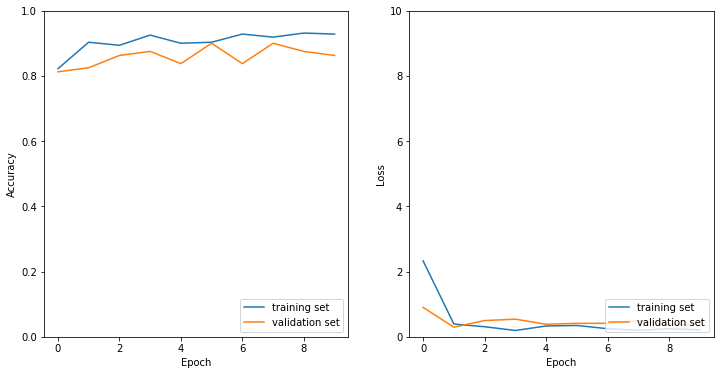

In [187]:
import tensorflow

def plot_history(history : tensorflow.python.keras.callbacks.History):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)